# Optics ray tracing tools in Python

In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import opticsRayTrace.rayTraceTools as rtt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ray

A ray is a line. It passes through a point **x** and travels along a direction specified by a vector **v**. By convention in my program, **x** is 3-dimensional, and given in mm, and **v** is assumed to be of unit length. An additional convention is that my program works best when rays travel roughly along the z-axis, i.e., the third dimension.

*Ray tracing* is the process of computing the path of an optical ray through a system that contains refractive and reflective materials, such as mirrors and lenses. Technically, it is the name given to an *approximate solution of Maxwell's equations* that works well enough to be useful for optics design. The approximation primarily *ignores the wave nature of light*.

## Sequential ray tracing

*Sequential* ray tracing is a method that assumes that a ray passes through a fixed sequence of interactions with *surfaces*. Once a ray has interacted with a surface, it *always* passes to the next surface in the list.

*Non-sequential* ray tracing avoids this assumption, and is more realistic for problems such as illumination and graphic rendering, but also more computationally intensive. The program has to search for the location of the next interaction. Most ray tracing for computer graphics is non-sequential.

My program is strictly sequential. This makes it computationally simpler. Most optics design starts out with sequential ray tracing, where the basic structure and performance of a design can be worked out. An engineer might also perform non-sequential tracing to analyze for things like stray and scattered light. But you can design a basic lens with sequential tracing, and it will work pretty well.

Because the program only computes interactions at surfaces, it doesn't care about the bulk material (or air / vacuum) between surfaces. You have to always be aware that the material is in fact doing things. Because air and vacuum have nearly the same refractive index, my program doesn't distinguish between them.

## Dummy surfaces, and our first ray trace

Dummy surfaces are used as planes with well defined positions but no other optical properties. They are usually used for the locations where rays originate and terminate in a design. So the simplest design is two dummy surfaces separated by a distance.

*For now, it's assumed that dummy surfaces are in air. If you want to make a transition between air and a material, you should use a conic surface with zero curvature.*

In [33]:
surface_list = [
    {"surf": "dummy",  # identifies the type of surface
     "dist": 20,  # distance to the next surface in mm
     "draw_radius": 5},  # radius of the surface when drawn in a graph
    {"surf": "dummy",
     "dist": 0,  # this is the last surface, no distance is needed
     "draw_radius": 5},
]

Let's whip through some operations, just to see what happens. The "geometry" takes the surface list and lays out the surfaces in space, with additional data needed for ray tracing. The origin and axes create a coordinate system that is local to the surface. The surface is defined in terms of that coordinate system.

In [31]:
geometry = rtt.build_geometry(surface_list)
geometry

[{'surf': 'dummy',
  'dist': 20,
  'draw_radius': 5,
  'draw_dx': 0,
  'draw_dy': 0,
  'origin': array([0, 0, 0]),
  'x_axis': array([1, 0, 0]),
  'y_axis': array([0, 1, 0]),
  'z_axis': array([0, 0, 1])},
 {'surf': 'dummy',
  'dist': 0,
  'draw_radius': 5,
  'draw_dx': 0,
  'draw_dy': 0,
  'origin': array([ 0,  0, 20]),
  'x_axis': array([1, 0, 0]),
  'y_axis': array([0, 1, 0]),
  'z_axis': array([0, 0, 1])}]

By convention, "field" refers to the source of rays, and "pupil" to an arbitrary plane that the rays pass through. A vector can be defined by a pair of intersection points on two planes. It's convenient to specify the rays being analyzed in terms of their locations on two planes.

surface ray x y z vx vy vz
0 0 [0. 0. 0.] [0.04993762 0.         0.99875234]
1 0 [ 1.  0. 20.] [0.04993762 0.         0.99875234]


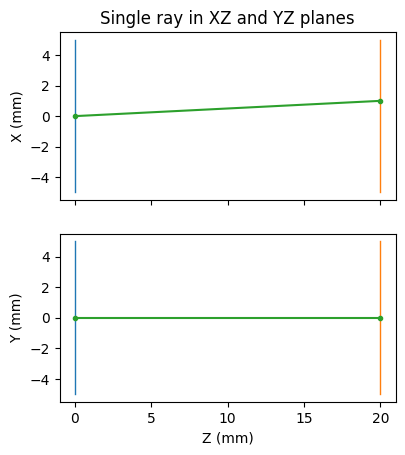

In [39]:
field_points = np.array([[0, 0, 0]])  # The rays go through this point in space
pupil_points = np.array([[1, 0, 20]])  # ... and through this point in space
wavls = [0.000633]  # The program needs a wavelength even if it's not used yet
# This function creates a table of rays with every possible combination of field, pupil, and wavelength
ray_table, _, _ = rtt.new_ray_table(geometry, field_points, pupil_points, wavls)
ray_properties = rtt.default_ray_properties(ray_table)
rtt.print_ray_table(ray_table)
# This right here is the ray tracing operation
rtt.propagate_ray(ray_table, ray_properties, geometry)
# The rest is graphing for convenience, showing the rays in the XZ and YZ planes
axd = rtt.new_plot_xy()
rtt.plot_faces(axd, geometry)
rtt.plot_rays(axd, geometry, ray_table, ray_properties, marker = '.')
axd["axs"][0].set_title("Single ray in XZ and YZ planes")
plt.show()

## Now we're ready to make a lens!

Text(0.5, 1.0, 'Single ray through basic lens')

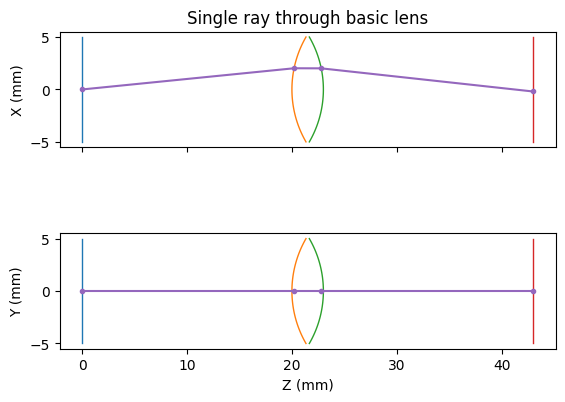

In [41]:
surface_list = [
    {"surf": "dummy", "dist": 20, "draw_radius": 5},
    {
        "surf": "conic",
        "dist": 3,
        "c": 1 / 10,  # curvature, is reciprocal of the radius of curvature
        "k": 0,  # conic constant, equal to zero for a spherical surface
        "n1": 1,  # this surface is a transition from air to glass
        "n2": 1.5,  # approximate refractive index of glass
        "draw_radius": 5,
    },
    {
        "surf": "conic",
        "dist": 20,
        "c": -1 / 10,  # curvature is negative to point the other way
        "k": 0,
        "n1": 1.5,  # transition from glass to air
        "n2": 1,  # approximate refractive index of air
        "draw_radius": 5,
    },
    {"surf": "dummy", "dist": 10, "draw_radius": 5}
]
geometry = rtt.build_geometry(surface_list)
field_points = np.array([[0, 0, 0]])
pupil_points = np.array([[1, 0, 10]])
ray_table = rtt.ray_table_from_fields_points(geometry, field_points, pupil_points)
ray_properties = rtt.default_ray_properties(ray_table)
rtt.propagate_ray(ray_table, ray_properties, geometry)
axd = rtt.new_plot_xy()
rtt.plot_faces(axd, geometry)
rtt.plot_rays(axd, geometry, ray_table, ray_properties, marker = '.')
axd["axs"][0].set_title("Single ray through basic lens")